# ...

In [ ]:
# %cd /content
# ! rm -r competition

In [1]:
! git clone https://github.com/Tikquuss/competition

Cloning into 'competition'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 155 (delta 82), reused 105 (delta 32), pack-reused 0
Receiving objects: 100% (155/155), 39.86 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
%cd competition/code

/content/competition/code


In [ ]:
#! python train_cnn.py --model_name test  --learning_rate 0.001 --weight_decay 0.0001 --scheduler False --n_epochs 50 --batch_size 512 --dropout_conv 0.0 --dropout_fc 0.0 --train_pct 90 --holdout_pct 10 --seed 0

In [ ]:
# !chmod +x train_loop.sh
# ! ./train_loop.sh test 2

In [5]:
# Imports from our code
from utils import DATA_PATH, DIR_PATH_FIGURES, DIR_PATH_SUBMISSIONS, H, W
from utils import predict_nontest, predict_test, save_for_submission, eval
from data import  get_dataset
from plotter import plot_training_curve, plot_cdf, custom_imshow, confusion_matrix, scores, plot_confusion_matrix, show_example_images

from model_cnn import MyCNN, MyCNN_2, ResNet
from trainer import Trainer, get_dataset_pytorch

In [6]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import tqdm
import copy


device = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE=torch.float64

# Fix random seed
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data

In [9]:
# HEIGHT, WIDTH = 10, 10
# HEIGHT, WIDTH = 27, 27
HEIGHT, WIDTH = None, None

scaler_class=None
#scaler_class='standard_scaler'
scaler_class='min_max_scaler'

train_transforms = transforms.Compose([
        transforms.Normalize((0.5,), (0.5,))
    ])

test_transforms = transforms.Compose([
        transforms.Normalize((0.5,), (0.5,))
    ])

train_pct, holdout_pct = 80, 10
#train_pct, holdout_pct = 90, 10
#train_pct, holdout_pct = 100,0

seed=0
n_classes=24

In [10]:
IDs_test, (X_tr, Y_tr, X_ht_test, Y_ht_test, X_val, Y_val, X_all, Y_all, X_test, X_test_all, X_ht_test_all, d) = get_dataset_pytorch(
    train_pct=train_pct, holdout_pct=holdout_pct, train_transforms=train_transforms, test_transforms=test_transforms,
    k_fold=False, HEIGHT=HEIGHT, WIDTH=WIDTH, do_over_sampling=False, do_under_sampling=False,
    scaler_class=scaler_class, is_pytorch=True, device=device, seed=seed
    )

784
normal, min, max : [0 0 0 0 0] [255 255 255 255 255]
all, min, max : [0 0 0 0 0] [255 255 255 255 255]
print(len(train_dataset), X_tr.shape, X_ht_test.shape, X_val.shape, X_test[0].shape, X_test[1].shape)
27455 torch.Size([21964, 1, 28, 28]) torch.Size([2745, 1, 28, 28]) torch.Size([2746, 1, 28, 28]) torch.Size([3000, 1, 28, 28]) torch.Size([3000, 1, 28, 28])


tensor(-1., device='cuda:0', dtype=torch.float64) tensor(1., device='cuda:0', dtype=torch.float64)


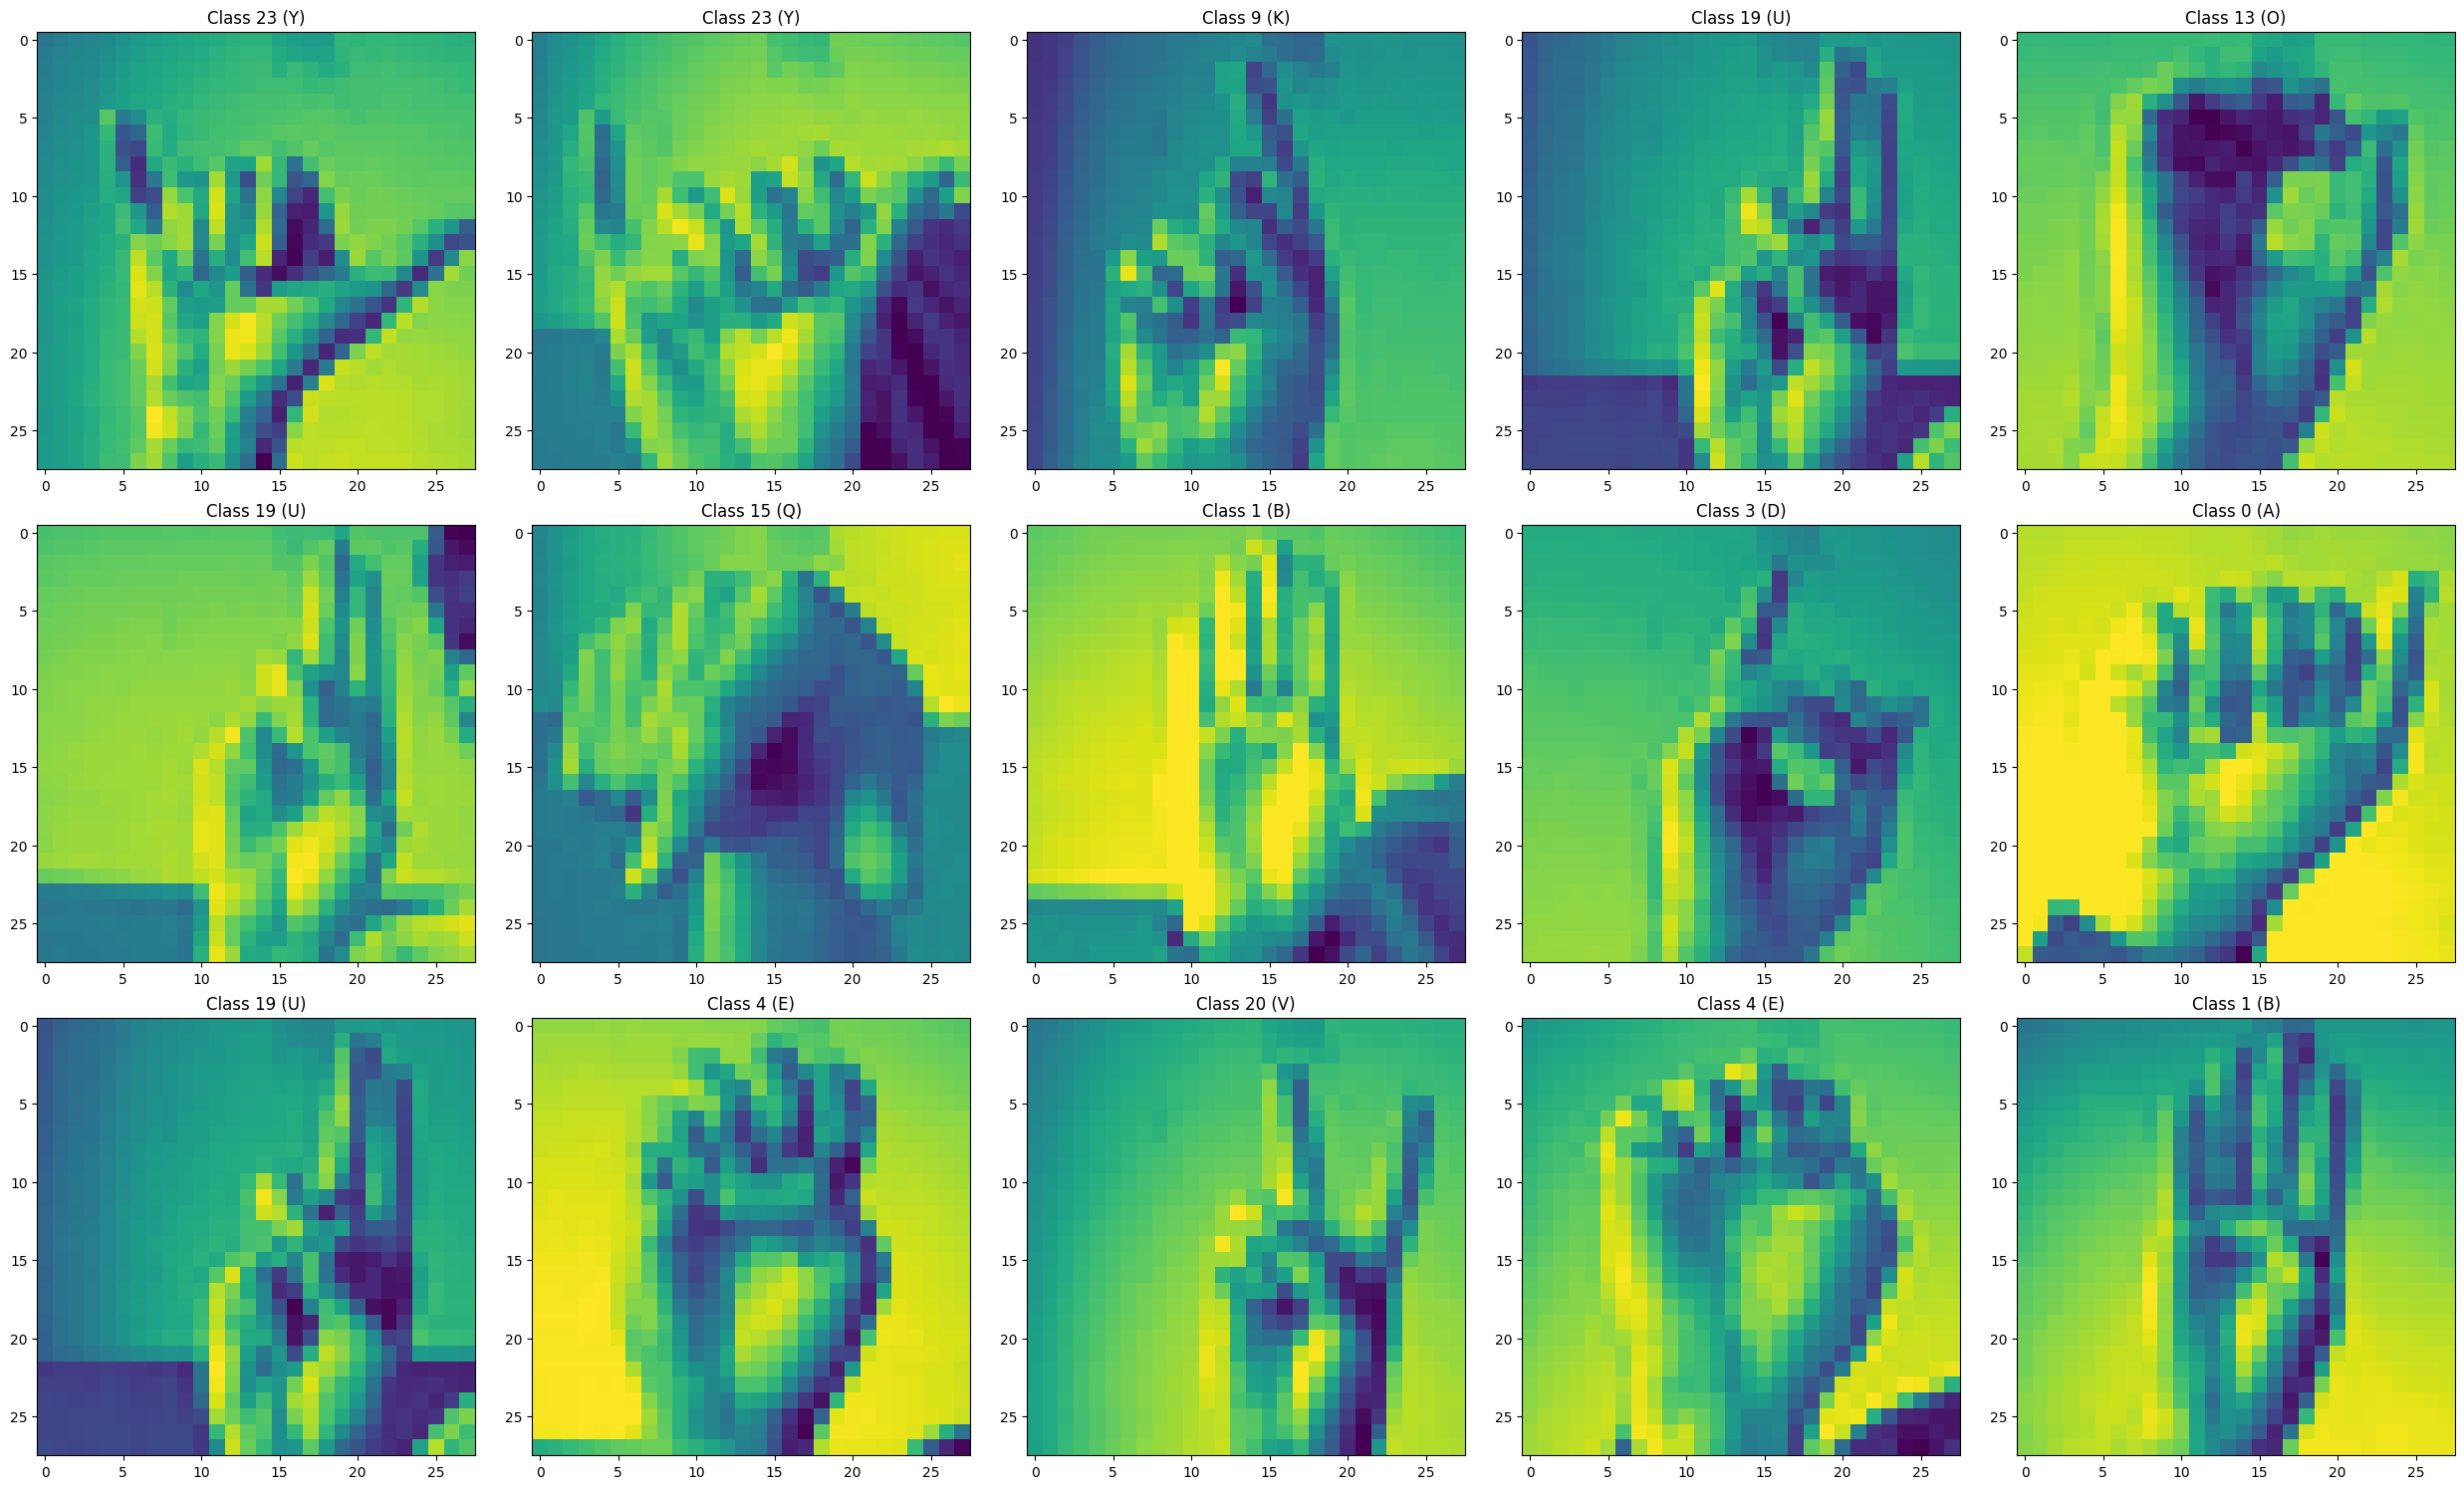

In [12]:
print(X_all.min(), X_all.max())
_ = show_example_images(X_tr.cpu().reshape(-1, X_tr.shape[-2], X_tr.shape[-1]), Y_tr.cpu(), n_imgs=15, mono = 'viridis')

In [ ]:
# IDs_test, kfold_iterator = get_dataset_pytorch(
#     train_pct=80, holdout_pct=10, train_transforms=train_transforms, test_transforms=test_transforms,
#     k_fold=True, HEIGHT=HEIGHT, WIDTH=WIDTH, do_over_sampling=False, do_under_sampling=False,
#     scaler_class=scaler_class, is_pytorch=True, device=device, seed=0)

# Train

In [13]:
n_classes=24
learning_rate=0.001
weight_decay=0.0001

n_epochs = 20 #
batch_size = 512#*2

fileName="test_CNN"

In [14]:
# SMALL CNN
model = MyCNN(n_classes=n_classes, dropout_conv=0.1, dropout_fc=0.1).to(DTYPE).to(device)
# Big CNN
#model = MyCNN_2(n_classes=n_classes, dropout_conv=0.1, dropout_fc=0.1).to(DTYPE).to(device)
# RestNet
# model = ResNet(n_classes=n_classes, dropout_conv=0.0, dropout_fc=0.0).to(DTYPE).to(device)

print(model)
optimizer = optim.AdamW(model.parameters(), learning_rate, weight_decay=weight_decay)
#lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
lr_scheduler = None
criterion = nn.CrossEntropyLoss()
checkpoint_path=f"{DIR_PATH_FIGURES}/{fileName}"
trainer = Trainer(model, criterion, optimizer, lr_scheduler, checkpoint_path)

MyCNN(
  (conv): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=270, out_features=24, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)


In [15]:
########################################################################
########################################################################

if train_pct + holdout_pct < 100 :
    train_accs, train_losses, val_accs, val_losses, best_acc = trainer.train(
        X_tr, Y_tr, X_val, Y_val, batch_size=batch_size, n_epochs = n_epochs, use_tqdm=True)
    train_acc = eval(trainer, X_tr, Y_tr)
    val_acc = eval(trainer, X_val, Y_val)
    test_acc = predict_nontest(trainer, X_ht_test, Y_ht_test, seed=0)

    conf_matrix_1 = confusion_matrix(Y_tr, trainer.test(X_tr), n_classes=n_classes)
    conf_matrix_2  = confusion_matrix(Y_ht_test, trainer.test(X_ht_test), n_classes=n_classes)

    Y_hat_A, Y_hat_B = predict_test(trainer, X_test)
else :
    train_accs, train_losses, val_accs, val_losses, best_acc = trainer.train(
        X_all, Y_all, X_val=None, Y_val=None, batch_size=batch_size, n_epochs = n_epochs, use_tqdm=True)
    train_acc = eval(trainer, X_all, Y_all)
    val_acc = -1
    test_acc = predict_nontest(trainer, X_ht_test_all, Y_ht_test, seed=0)

    conf_matrix_1 = confusion_matrix(Y_all, trainer.test(X_all), n_classes=n_classes)
    conf_matrix_2 = confusion_matrix(Y_ht_test, trainer.test(X_ht_test_all), n_classes=n_classes)

    Y_hat_A, Y_hat_B = predict_test(trainer, X_test_all)

########################################################################
########################################################################

print("train acc : {:7.4f} % \nvalidation acc : {:7.4f}".format(train_acc * 100, val_acc * 100))
print(test_acc)

Training ...:   5%|▌         | 1/20 [00:02<00:39,  2.06s/it]


 Epoch: 0 | Train Acc: 0.569386 | Train Loss: 1.736338 | Val Acc: 0.810998   | Val Loss: 0.808311


Training ...:  10%|█         | 2/20 [00:03<00:30,  1.70s/it]


 Epoch: 1 | Train Acc: 0.904935 | Train Loss: 0.373402 | Val Acc: 0.973416   | Val Loss: 0.153059


Training ...:  15%|█▌        | 3/20 [00:04<00:26,  1.58s/it]


 Epoch: 2 | Train Acc: 0.981014 | Train Loss: 0.118715 | Val Acc: 0.999272   | Val Loss: 0.047551


Training ...:  20%|██        | 4/20 [00:06<00:24,  1.52s/it]


 Epoch: 3 | Train Acc: 0.994582 | Train Loss: 0.052758 | Val Acc: 1.000000   | Val Loss: 0.017609


Training ...:  25%|██▌       | 5/20 [00:07<00:22,  1.49s/it]


 Epoch: 4 | Train Acc: 0.997041 | Train Loss: 0.032316 | Val Acc: 1.000000   | Val Loss: 0.010982


Training ...:  30%|███       | 6/20 [00:09<00:20,  1.47s/it]


 Epoch: 5 | Train Acc: 0.998498 | Train Loss: 0.020411 | Val Acc: 1.000000   | Val Loss: 0.007398


Training ...:  35%|███▌      | 7/20 [00:10<00:18,  1.46s/it]


 Epoch: 6 | Train Acc: 0.998224 | Train Loss: 0.015840 | Val Acc: 1.000000   | Val Loss: 0.004764


Training ...:  40%|████      | 8/20 [00:12<00:17,  1.45s/it]


 Epoch: 7 | Train Acc: 0.998589 | Train Loss: 0.012984 | Val Acc: 1.000000   | Val Loss: 0.003429


Training ...:  45%|████▌     | 9/20 [00:13<00:15,  1.45s/it]


 Epoch: 8 | Train Acc: 0.998862 | Train Loss: 0.010331 | Val Acc: 1.000000   | Val Loss: 0.002427


Training ...:  50%|█████     | 10/20 [00:14<00:14,  1.45s/it]


 Epoch: 9 | Train Acc: 0.999545 | Train Loss: 0.007568 | Val Acc: 1.000000   | Val Loss: 0.001784


Training ...:  55%|█████▌    | 11/20 [00:16<00:12,  1.44s/it]


 Epoch: 10 | Train Acc: 0.999681 | Train Loss: 0.006429 | Val Acc: 1.000000   | Val Loss: 0.001501


Training ...:  60%|██████    | 12/20 [00:17<00:11,  1.44s/it]


 Epoch: 11 | Train Acc: 0.999499 | Train Loss: 0.005545 | Val Acc: 1.000000   | Val Loss: 0.001587


Training ...:  65%|██████▌   | 13/20 [00:19<00:10,  1.44s/it]


 Epoch: 12 | Train Acc: 0.999454 | Train Loss: 0.004980 | Val Acc: 1.000000   | Val Loss: 0.001307


Training ...:  70%|███████   | 14/20 [00:20<00:08,  1.44s/it]


 Epoch: 13 | Train Acc: 0.999727 | Train Loss: 0.004705 | Val Acc: 1.000000   | Val Loss: 0.001053


Training ...:  75%|███████▌  | 15/20 [00:22<00:07,  1.44s/it]


 Epoch: 14 | Train Acc: 0.999590 | Train Loss: 0.004028 | Val Acc: 1.000000   | Val Loss: 0.000799


Training ...:  80%|████████  | 16/20 [00:23<00:05,  1.44s/it]


 Epoch: 15 | Train Acc: 0.999681 | Train Loss: 0.003481 | Val Acc: 1.000000   | Val Loss: 0.000835


Training ...:  85%|████████▌ | 17/20 [00:25<00:04,  1.44s/it]


 Epoch: 16 | Train Acc: 0.999954 | Train Loss: 0.002851 | Val Acc: 1.000000   | Val Loss: 0.000608


Training ...:  90%|█████████ | 18/20 [00:26<00:02,  1.45s/it]


 Epoch: 17 | Train Acc: 0.999772 | Train Loss: 0.002624 | Val Acc: 1.000000   | Val Loss: 0.000549


Training ...:  95%|█████████▌| 19/20 [00:27<00:01,  1.44s/it]


 Epoch: 18 | Train Acc: 0.999909 | Train Loss: 0.002325 | Val Acc: 1.000000   | Val Loss: 0.000407


Training ...: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


 Epoch: 19 | Train Acc: 0.999909 | Train Loss: 0.002573 | Val Acc: 1.000000   | Val Loss: 0.000649


train acc : 99.9954 % 
validation acc : 100.0000
(100.0, 100.0)


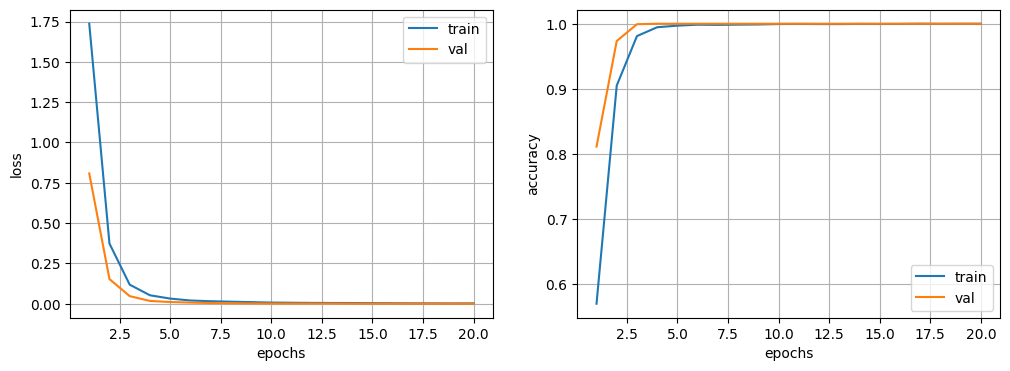

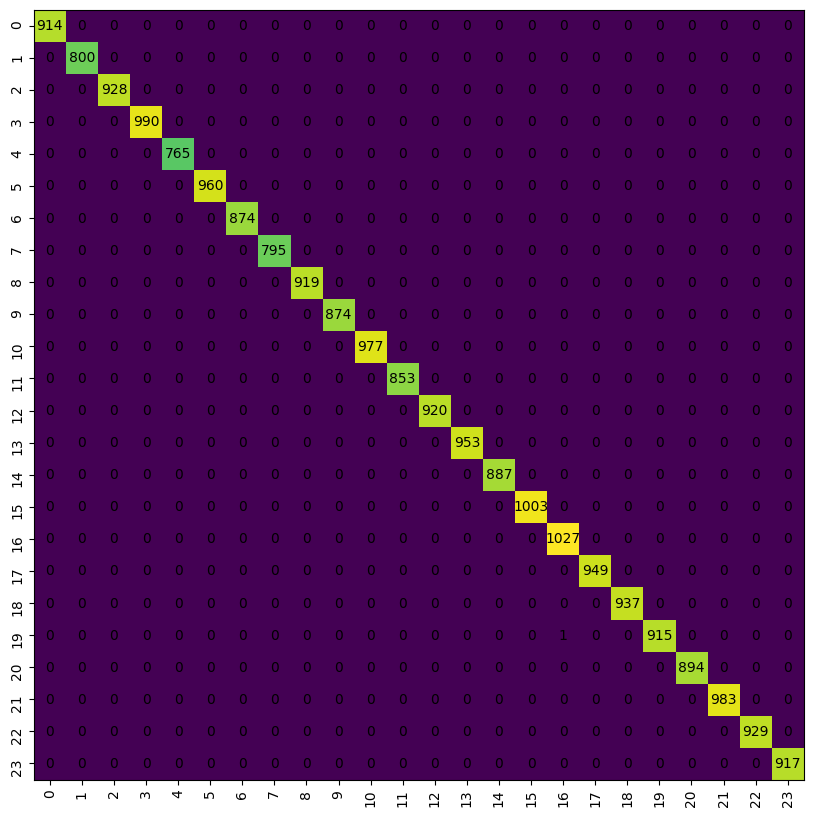

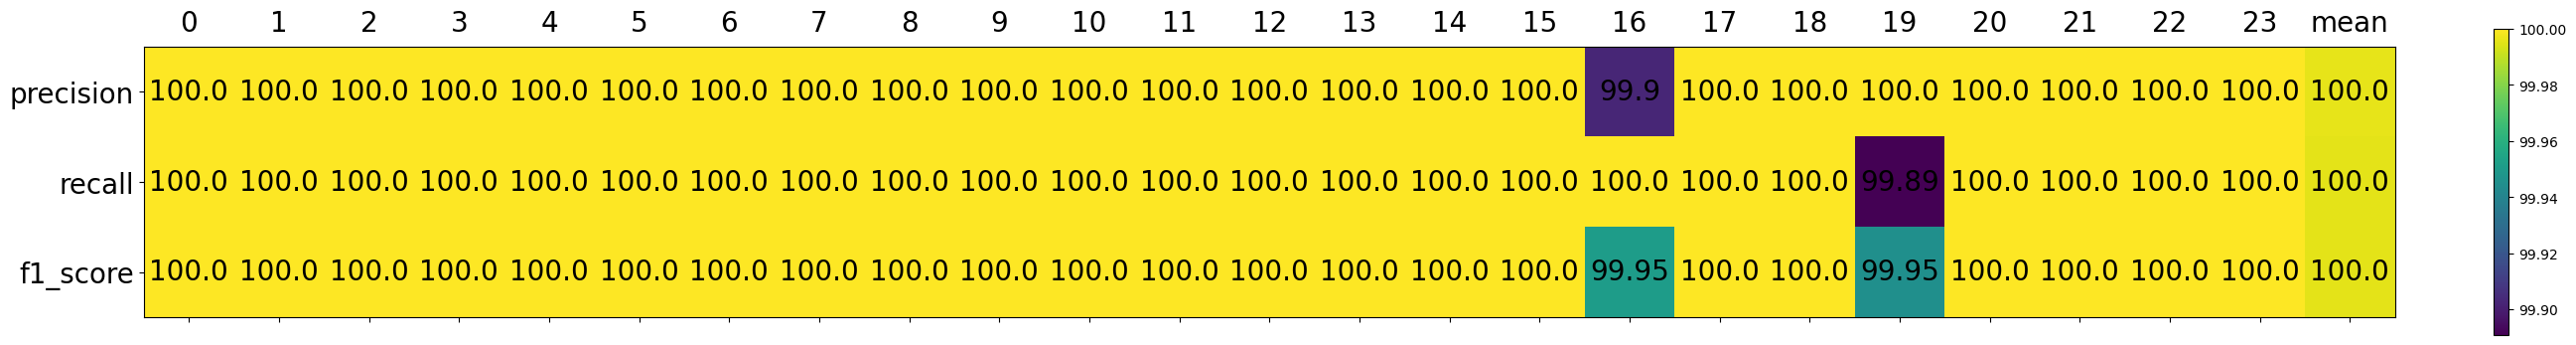

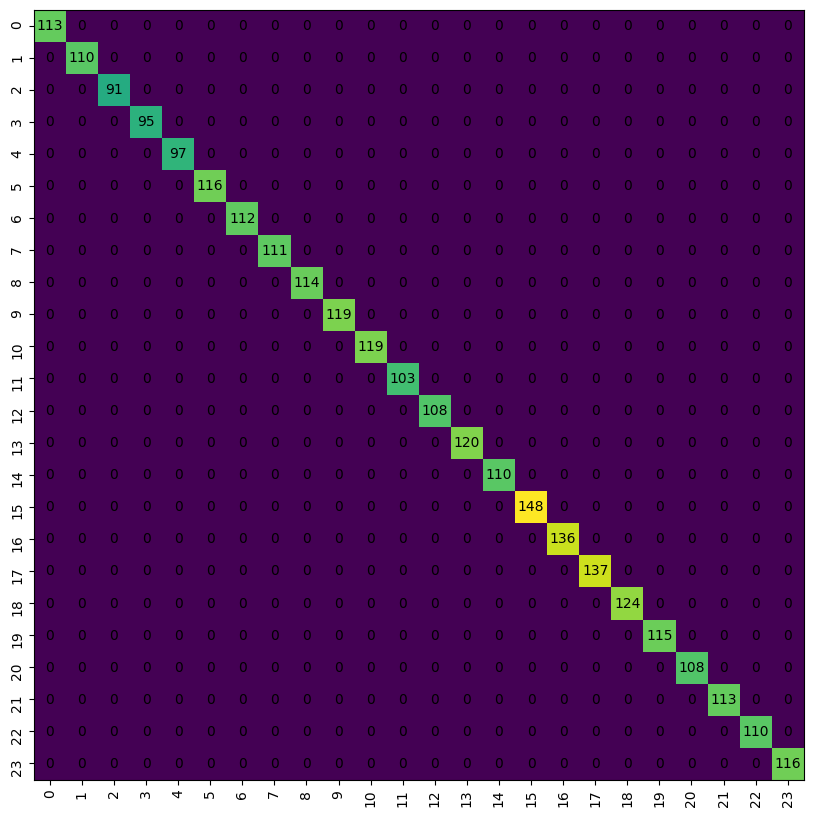

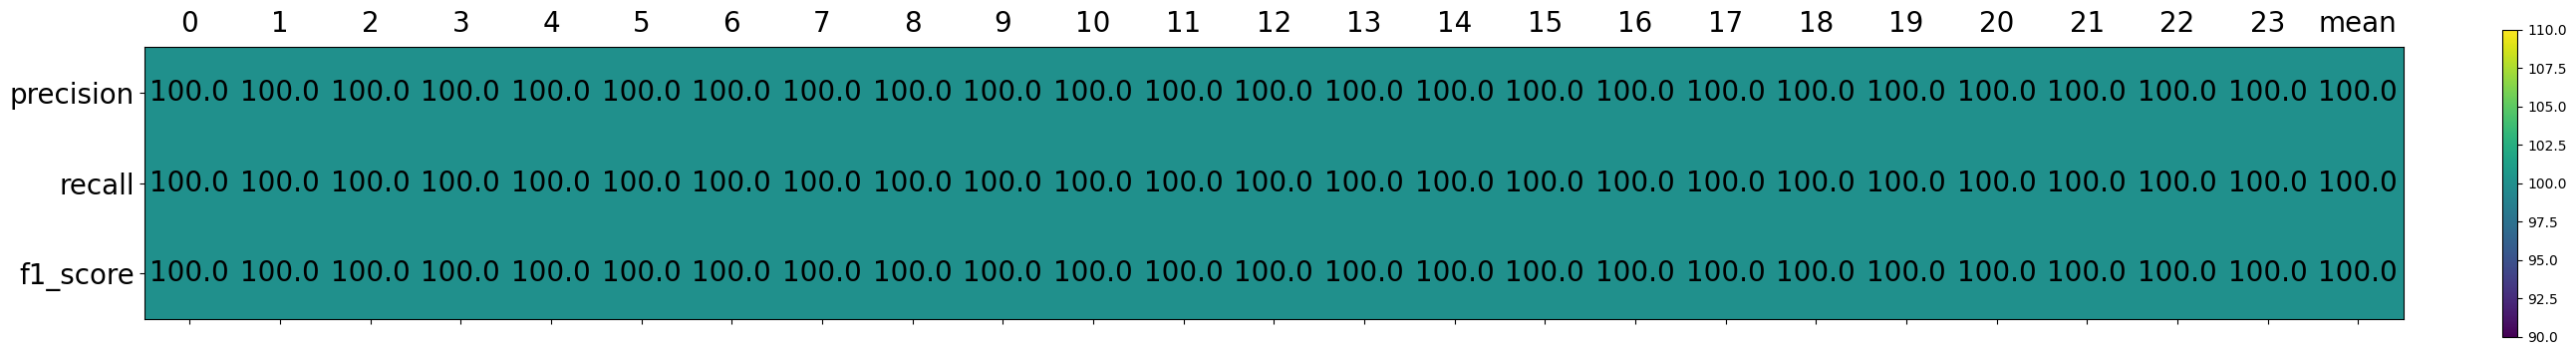

In [17]:
plot_training_curve(n_epochs, train_losses, train_accs, val_losses, val_accs, fileName = fileName)

plot_confusion_matrix(conf_matrix_1, fileName=f"{fileName}_train")
_ = scores(conf_matrix_1, fileName=f"{fileName}_train")

plot_confusion_matrix(conf_matrix_2, fileName=f"{fileName}_test")
_ = scores(conf_matrix_2, fileName=f"{fileName}_test")

Counter({'Y': 117, 'V': 111, 'W': 109, 'Z': 106, '\\': 101, 'R': 101, 'S': 101, ']': 99, '[': 99, 'T': 97, 'P': 93, 'U': 93, 'X': 92, 'M': 89, 'Q': 88, '^': 86, 'N': 82, 'O': 81, 'I': 73, 'b': 71, 'L': 70, 'H': 70, 'K': 68, 'J': 64, '`': 62, '_': 58, 'G': 57, 'a': 52, 'c': 51, 'f': 51, 'F': 48, 'e': 44, 'g': 43, 'd': 41, 'j': 35, 'h': 35, 'E': 32, 'D': 30, 'i': 29, 'k': 28, 'm': 26, 'C': 22, 'B': 20, 'l': 18, 'n': 16, 'A': 13, 'o': 10, 'q': 9, 'p': 9})


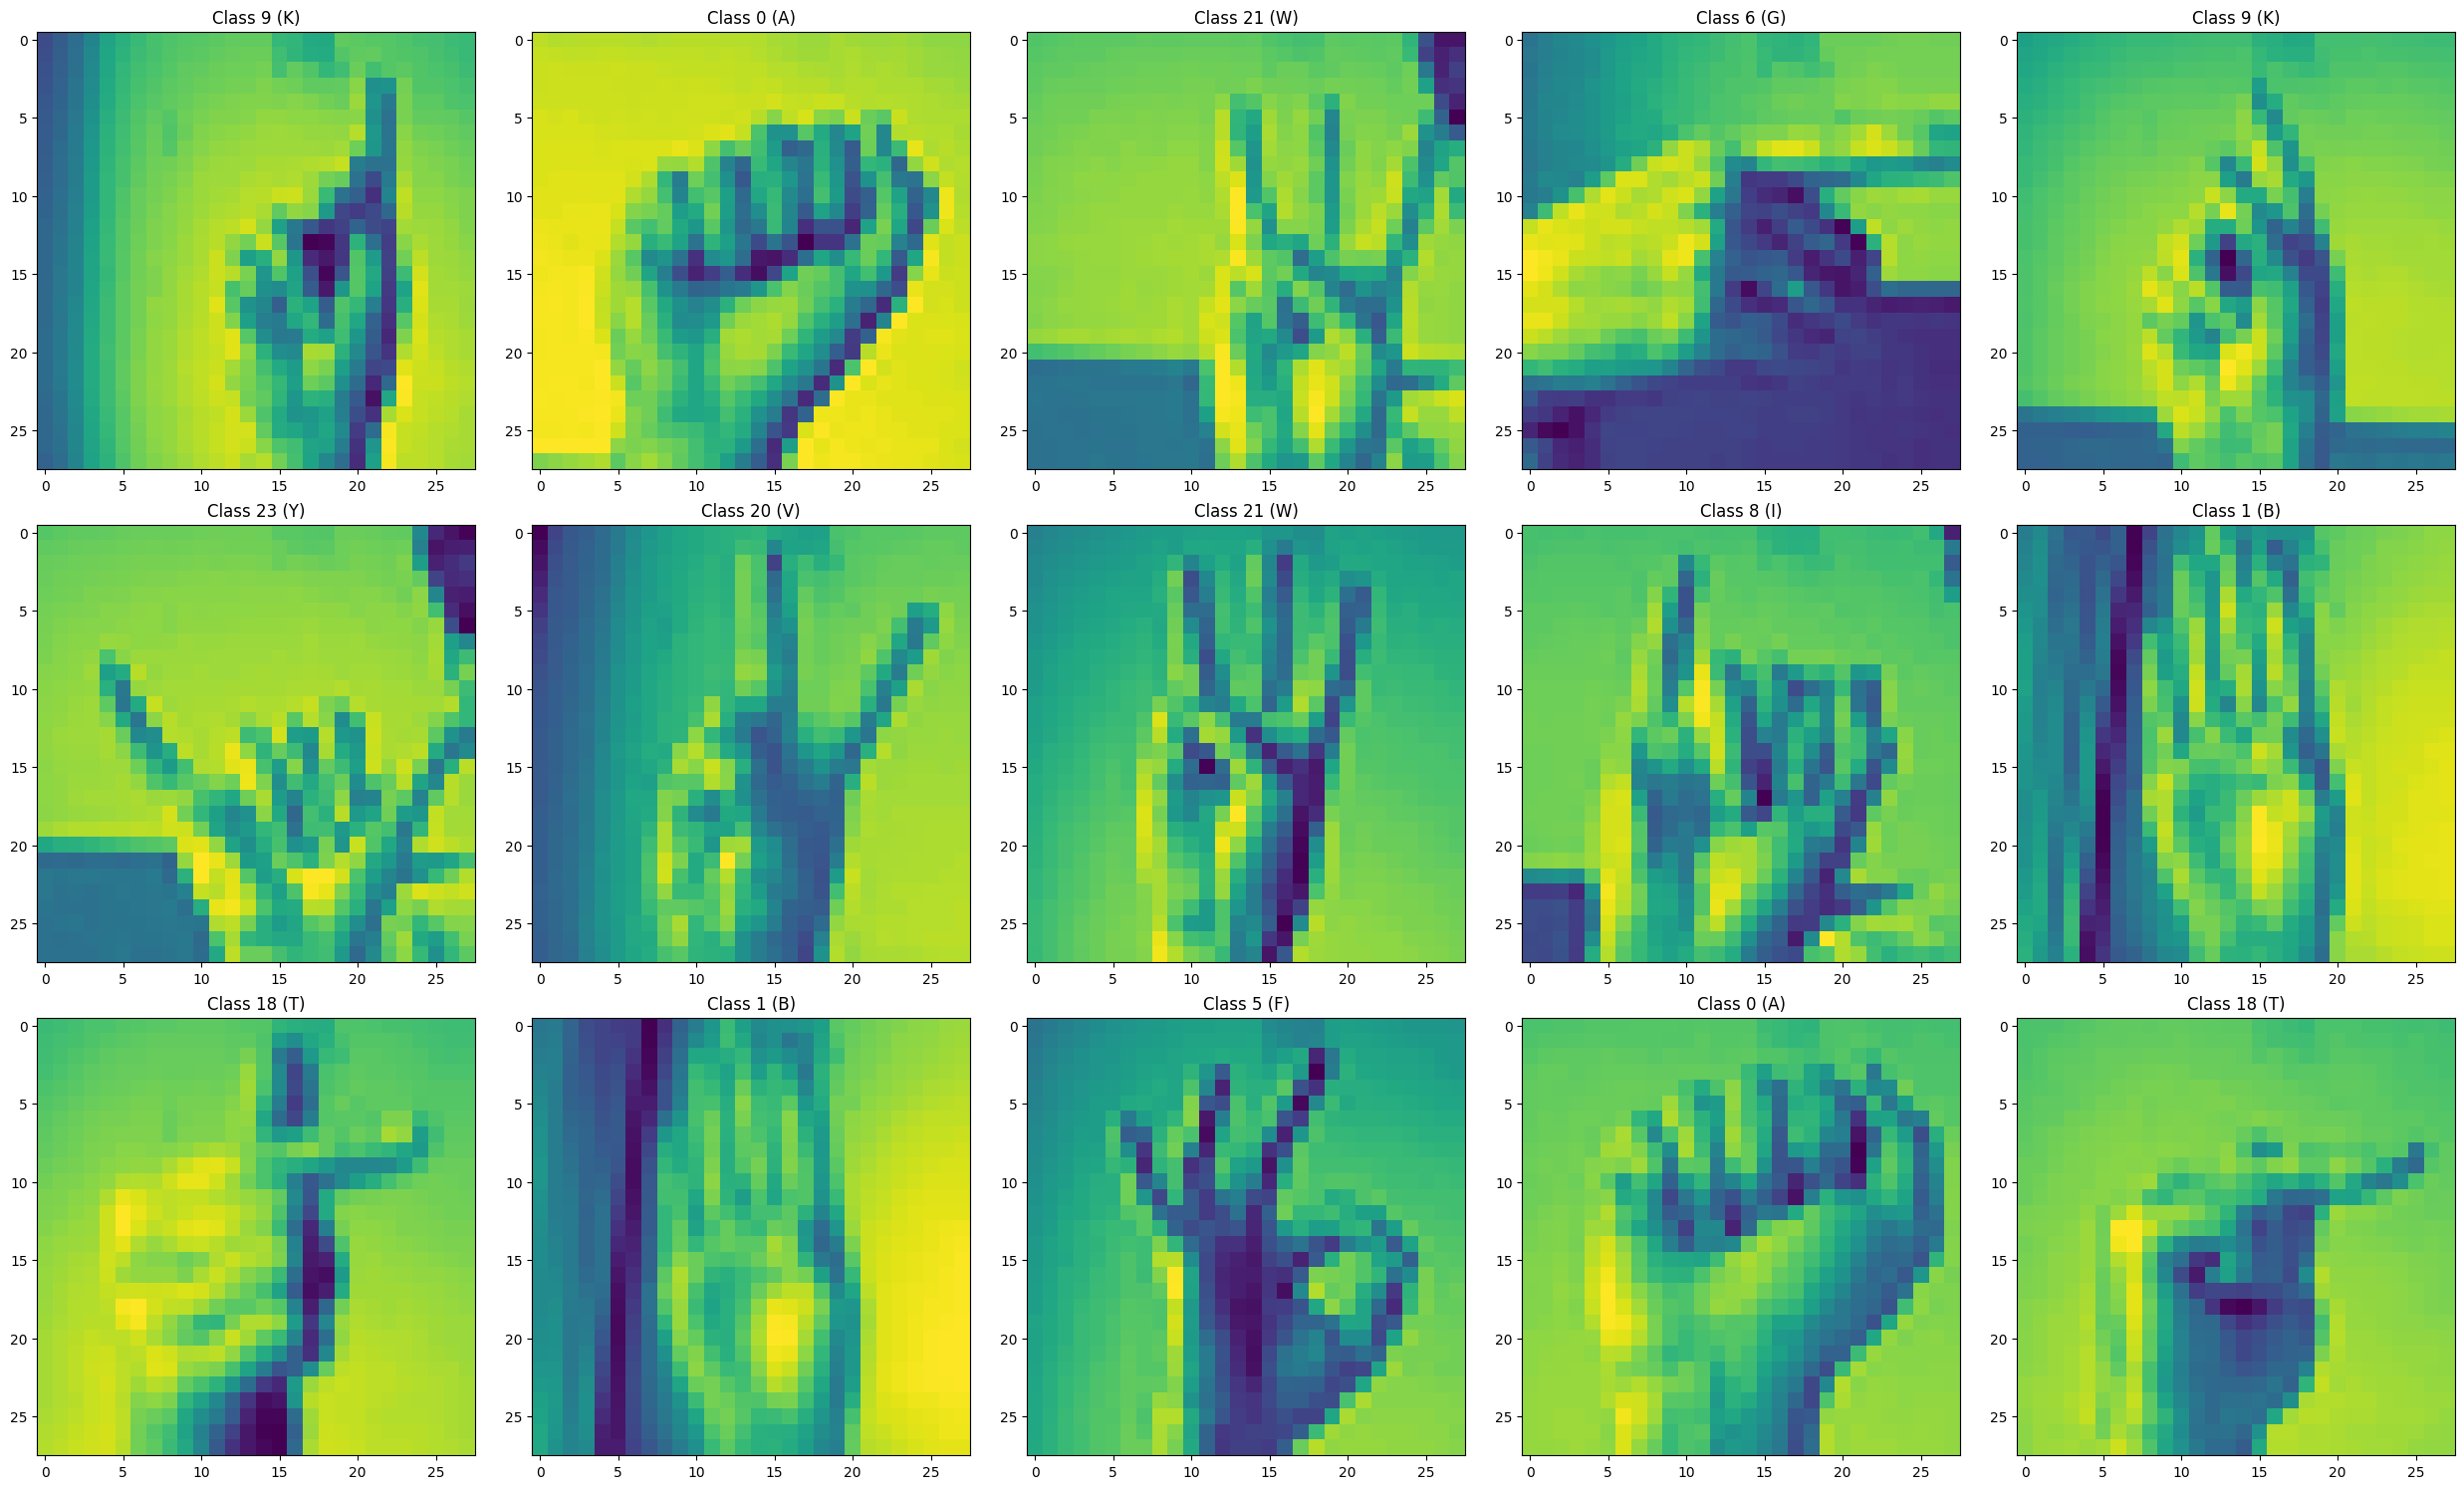

In [19]:
save_for_submission(IDs_test, Y_hat_A, Y_hat_B, fileName=f"{fileName}.csv")
i=0
_=show_example_images(X_test[i].cpu().reshape(-1, X_test_all[i].shape[-2], X_test_all[i].shape[-1]), [Y_hat_A, Y_hat_B][i].cpu(), n_imgs=15, mono = 'viridis')

In [20]:
to_save = {
    "trainer" : trainer,
    "perfs" : [train_acc, val_acc, test_acc],
    "others" : [conf_matrix_1, conf_matrix_2],
    "Y_hat_test" : [Y_hat_A, Y_hat_B]
}
torch.save(to_save, f"{DIR_PATH_FIGURES}/{fileName}.pth")